<a href="https://colab.research.google.com/github/bryanMontoya/mlTalleres/blob/main/Taller2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Talle 2 machine learning:
- Johjan Stiven Puerta Castaño
- Brayan Montoya Osorio

In [366]:
#Sección de importación de librerías.
import numpy as np
import random
import statistics
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
from statistics import mode
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

In [367]:
path = 'drive/MyDrive/reviews_sentiment.csv'
dataframe = pd.read_csv(path , sep = ';')
X = dataframe[['wordcount','sentimentValue']].values 
y = dataframe['Star Rating'].values 
dataframe.head(10)

,Review Title,Review Text,wordcount,titleSentiment,textSentiment,Star Rating,sentimentValue
0,Sin conexión,Hola desde hace algo más de un mes me pone sin...,23,negative,negative,1,-0.486389
1,faltan cosas,Han mejorado la apariencia pero no,20,negative,negative,1,-0.586187
2,Es muy buena lo recomiendo,Andres e puto amoooo,4,NaN,negative,1,-0.602240
3,Version antigua,Me gustana mas la version anterior esta es mas...,17,NaN,negative,1,-0.616271
4,Esta bien,Sin ser la biblia.... Esta bien,6,negative,negative,1,-0.651784
5,Buena,Nada del otro mundo pero han mejorado mucho,8,positive,negative,1,-0.720443
6,De gran ayuda,"Lo malo q necesita de …,pero la app es muy buena",23,positive,negative,1,-0.726825
7,Muy buena,"Estaba más acostumbrado al otro diseño, pero e...",16,positive,negative,1,-0.736769
8,Ta to guapa.,Va de escándalo,21,positive,negative,1,-0.765284
9,Se han corregido,Han corregido muchos fallos pero el diseño es ...,13,negative,negative,1,-0.797961


# **Punto 1**

In [368]:
#Descripcion: Función encargada de calcular la distancia minkowsky 'p' de una muestra dada, a un número determinado de vecinos.     
def calculateMinkowsky(p, sampleList, featuresMatrix, labels):    
  distances, labelsSorted, minkowskySorted = [],[],[]  
  for feature in featuresMatrix:    
    minkowsky = 0
    for i in range(len(sampleList)):
      minkowsky += (abs(sampleList[i] - feature[i]))**p      
    minkowsky = (minkowsky)**(1/p)
    distances.append(minkowsky)        
       
  distancesLabelsSorted = dict(zip(distances, labels))
  distances = sorted(distances)  
  for d in distances:
    labelsSorted.append(distancesLabelsSorted[d])
  minkowskySorted = list(zip(distances, labelsSorted))
  return minkowskySorted

In [369]:
print('Minkowsky/ Etiqueta')
matrix = (calculateMinkowsky(p = 2, sampleList = np.array([1,2,3]), featuresMatrix = np.array([[0,1,5],[0,6,70],[3,3,3],[3,4.5,-2],[4,-5,-4.5],[-2,5,0],[5.25,0,0]]), labels = np.array([1,2,3,4,5,2,0])))
for m in matrix:
  print(m)

Minkowsky/ Etiqueta
(2.23606797749979, 3)
(2.449489742783178, 1)
(5.196152422706632, 2)
(5.573374202401989, 0)
(5.937171043518958, 4)
(10.688779163215974, 5)
(67.12674578735364, 2)


# **Punto2**

In [370]:
def Matriz_plt(conf_Matrix, numClases):
  axis=np.arange(numClases+1)
  sb.heatmap(conf_Matrix, center=0, annot=True, fmt=".2f",
             cmap="YlGnBu", linewidths=.5, cbar=True, 
             xticklabels=axis, yticklabels=axis);               
  plt.title("Confusion Matrix")
  plt.xlabel('Predicciones')
  plt.ylabel('Real')

In [371]:
#Descripción: Función para realizar las métricas de desempeño (recall, presición, F1score y matriz de confusión)
def metrics(yreal, ypred, plotMatriz):
  xx = []
  xx.append(int(np.max(yreal)))
  xx.append(int(np.max(ypred)))
  numClases = max(xx)  
  acc=0

  conf_Matrix = np.zeros((numClases+1,numClases+1))
  rec=np.zeros(numClases+1)
  pre=np.zeros(numClases+1)
  f1=np.zeros(numClases+1)
  for i in range(len(yreal)):
    y = int (ypred[i])
    x = int (yreal[i])
    aux = conf_Matrix[x,y]
    conf_Matrix[x,y] = aux + 1
  
  if (plotMatriz):
    Matriz_plt(conf_Matrix, numClases)
  
  for i in range(len(conf_Matrix)):
    rec[i] = conf_Matrix[i,i]/np.sum(conf_Matrix[i,:])    
  
  for i in range(len(conf_Matrix)):
    pre[i] = conf_Matrix[i][i]/sum(conf_Matrix[:,i])      
  
  acc = np.diagonal(conf_Matrix).sum()/np.sum(conf_Matrix)  

  for i in range(len(rec)):
    f1[i]=2*(pre[i]*rec[i])/(pre[i]+rec[i])    
  
  return acc, pre, rec, f1

# **Punto 3**

In [372]:
#Descripción: Función encargada de dividir entre train y test además de aplicar estandarización a la matriz de características.
def estandarizar(paramEstandarizacion, X_train, X_test):    
    #Estandarización Min-Max.
    if (paramEstandarizacion == 1):
        for feature in range(X_train.shape[1]):
            xx = X_train[: , feature]
            x_min = xx.min()
            x_max = xx.max()        
            for i in range(len(X_train)):
                X_train[i , feature] = (X_train[i , feature] - x_min)/(x_max - x_min)  
            for i in range(len(X_test)):
                X_test[i , feature] = (X_test[i , feature] - x_min)/(x_max - x_min)    
    #Estandarización Z-score.    
    elif (paramEstandarizacion == 2):
        for feature in range(X_train.shape[1]):
            xx = X_train[: , feature]            
            mean = np.mean(xx)
            std = np.std(xx)
            for i in range(len(X_train)):
                X_train[i , feature] = (X_train[i , feature] - mean)/std  
            for i in range(len(X_test)):
                X_test[i , feature] = (X_test[i , feature] - mean)/std    
    return X_train, X_test

In [373]:
#Descripción: Función encargada de realizar una predicción para n muestras de test y presentar métricas.
def KNN(kNeighbors, X_train, X_test, y_train, y_test, paramEstandarizacion, plotMatriz):
  if (kNeighbors > len(X_train)):
    return "El número de vecinos es mayor a la cantidad de muestras de entrenamiento."
  else:    
    X_train, X_test = estandarizar(paramEstandarizacion, X_train, X_test)        
    predictedLabels = []
    for xx_test in X_test:      
      labelsSorted = calculateMinkowsky(p = 2, sampleList = xx_test, featuresMatrix = X_train, labels = y_train)                    
      knnLabels = []      
      for k in range(kNeighbors):
        knnLabels.append(labelsSorted[k][1])      

      try:
        predictedLabels.append(int(mode(knnLabels)))
      except:
        predictedLabels.append(int(knnLabels[1]))     
    
    predictedLabels = np.array(predictedLabels)      
    acc, pre, rec, f1 = metrics(y_test, predictedLabels, plotMatriz = plotMatriz)
  return acc, pre, rec, f1

### **Punto 4.**

In [374]:
#Descripción: Función encargada de realizar validación cruzada para encontrar un valor de k óptimo. Esta recibe una lista de k para evaluar, los datos de entrenamiento y el número de folds.
def crossValidation(kList, data, labels, nFolds, plotMatriz):    
  X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size = 0.2, random_state = 4)
  promedio = []
  for k in kList:
    accuracy = []
    for nFold in range(nFolds):
      #Generar diferentes folder a través del random_state con train_test_split.
      X_trainCV, X_testCV, y_trainCV, y_testCV = train_test_split(X_train, y_train, test_size = 0.2, random_state = nFold)    
      acc,_,_,_ = KNN(kNeighbors = k, X_train = X_trainCV, X_test = X_testCV, y_train = y_trainCV, y_test = y_testCV, paramEstandarizacion = 1, plotMatriz = plotMatriz)
      accuracy.append(acc)             
    promedio.append(statistics.mean(accuracy))

  return kList[promedio.index(max(promedio))], X_train, X_test, y_train, y_test

# **Punto 5.**

In [375]:
#Parámetros configurables por el usuario. Una lista de k para probar, y el número de folds que desea.
#------------------------------------------
#------------------------------------------
kList = np.array([4,5,6,7])
nFolds = 5
#1 para estandarizacion min-max, 2 para estadarizacion z-score, otro para no hacer estandarización.
paramEstandarizacion = 1 
#------------------------------------------
#------------------------------------------

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


Métricas:
Clase 0
Precision : nan
Recall    : nan
F1-Score  : nan
Clase 1
Precision : 1.00
Recall    : 1.00
F1-Score  : 1.00
Clase 2
Precision : 0.50
Recall    : 0.67
F1-Score  : 0.57
Clase 3
Precision : 0.94
Recall    : 0.88
F1-Score  : 0.91
Clase 4
Precision : 1.00
Recall    : 0.50
F1-Score  : 0.67
Clase 5
Precision : 0.86
Recall    : 1.00
F1-Score  : 0.92
 
Accuracy: 88.46 %
 
Confusion Matrix:


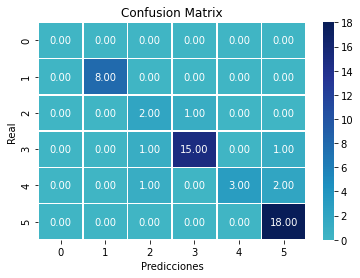

In [376]:
#Encontrar la mejor k a través de validación cruzada.
bestK, X_train, X_test, y_train, y_test = crossValidation(kList = kList, data = X, labels = y, nFolds = nFolds, plotMatriz = False)
acc, pre, rec, f1 = KNN(bestK, X_train, X_test, y_train, y_test, paramEstandarizacion, plotMatriz = True)
##--------------------Presentar métricas.------------------
print("Métricas:")
for i in range(len(pre)):
  print("Clase",i)
  print("Precision : {:.2f}".format(pre[i]))
  print("Recall    : {:.2f}".format(rec[i]))
  print("F1-Score  : {:.2f}".format(f1[i]))

print(" ")
print("Accuracy: {:.2f}".format(acc*100) + " %")
print(" ")

print("Confusion Matrix:")